In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('tomato', 
                                                             shuffle=True,
                                                             image_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                             batch_size = BATCH_SIZE
                                                             )

Found 16011 files belonging to 10 classes.


In [5]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [21]:
len(class_names)

10

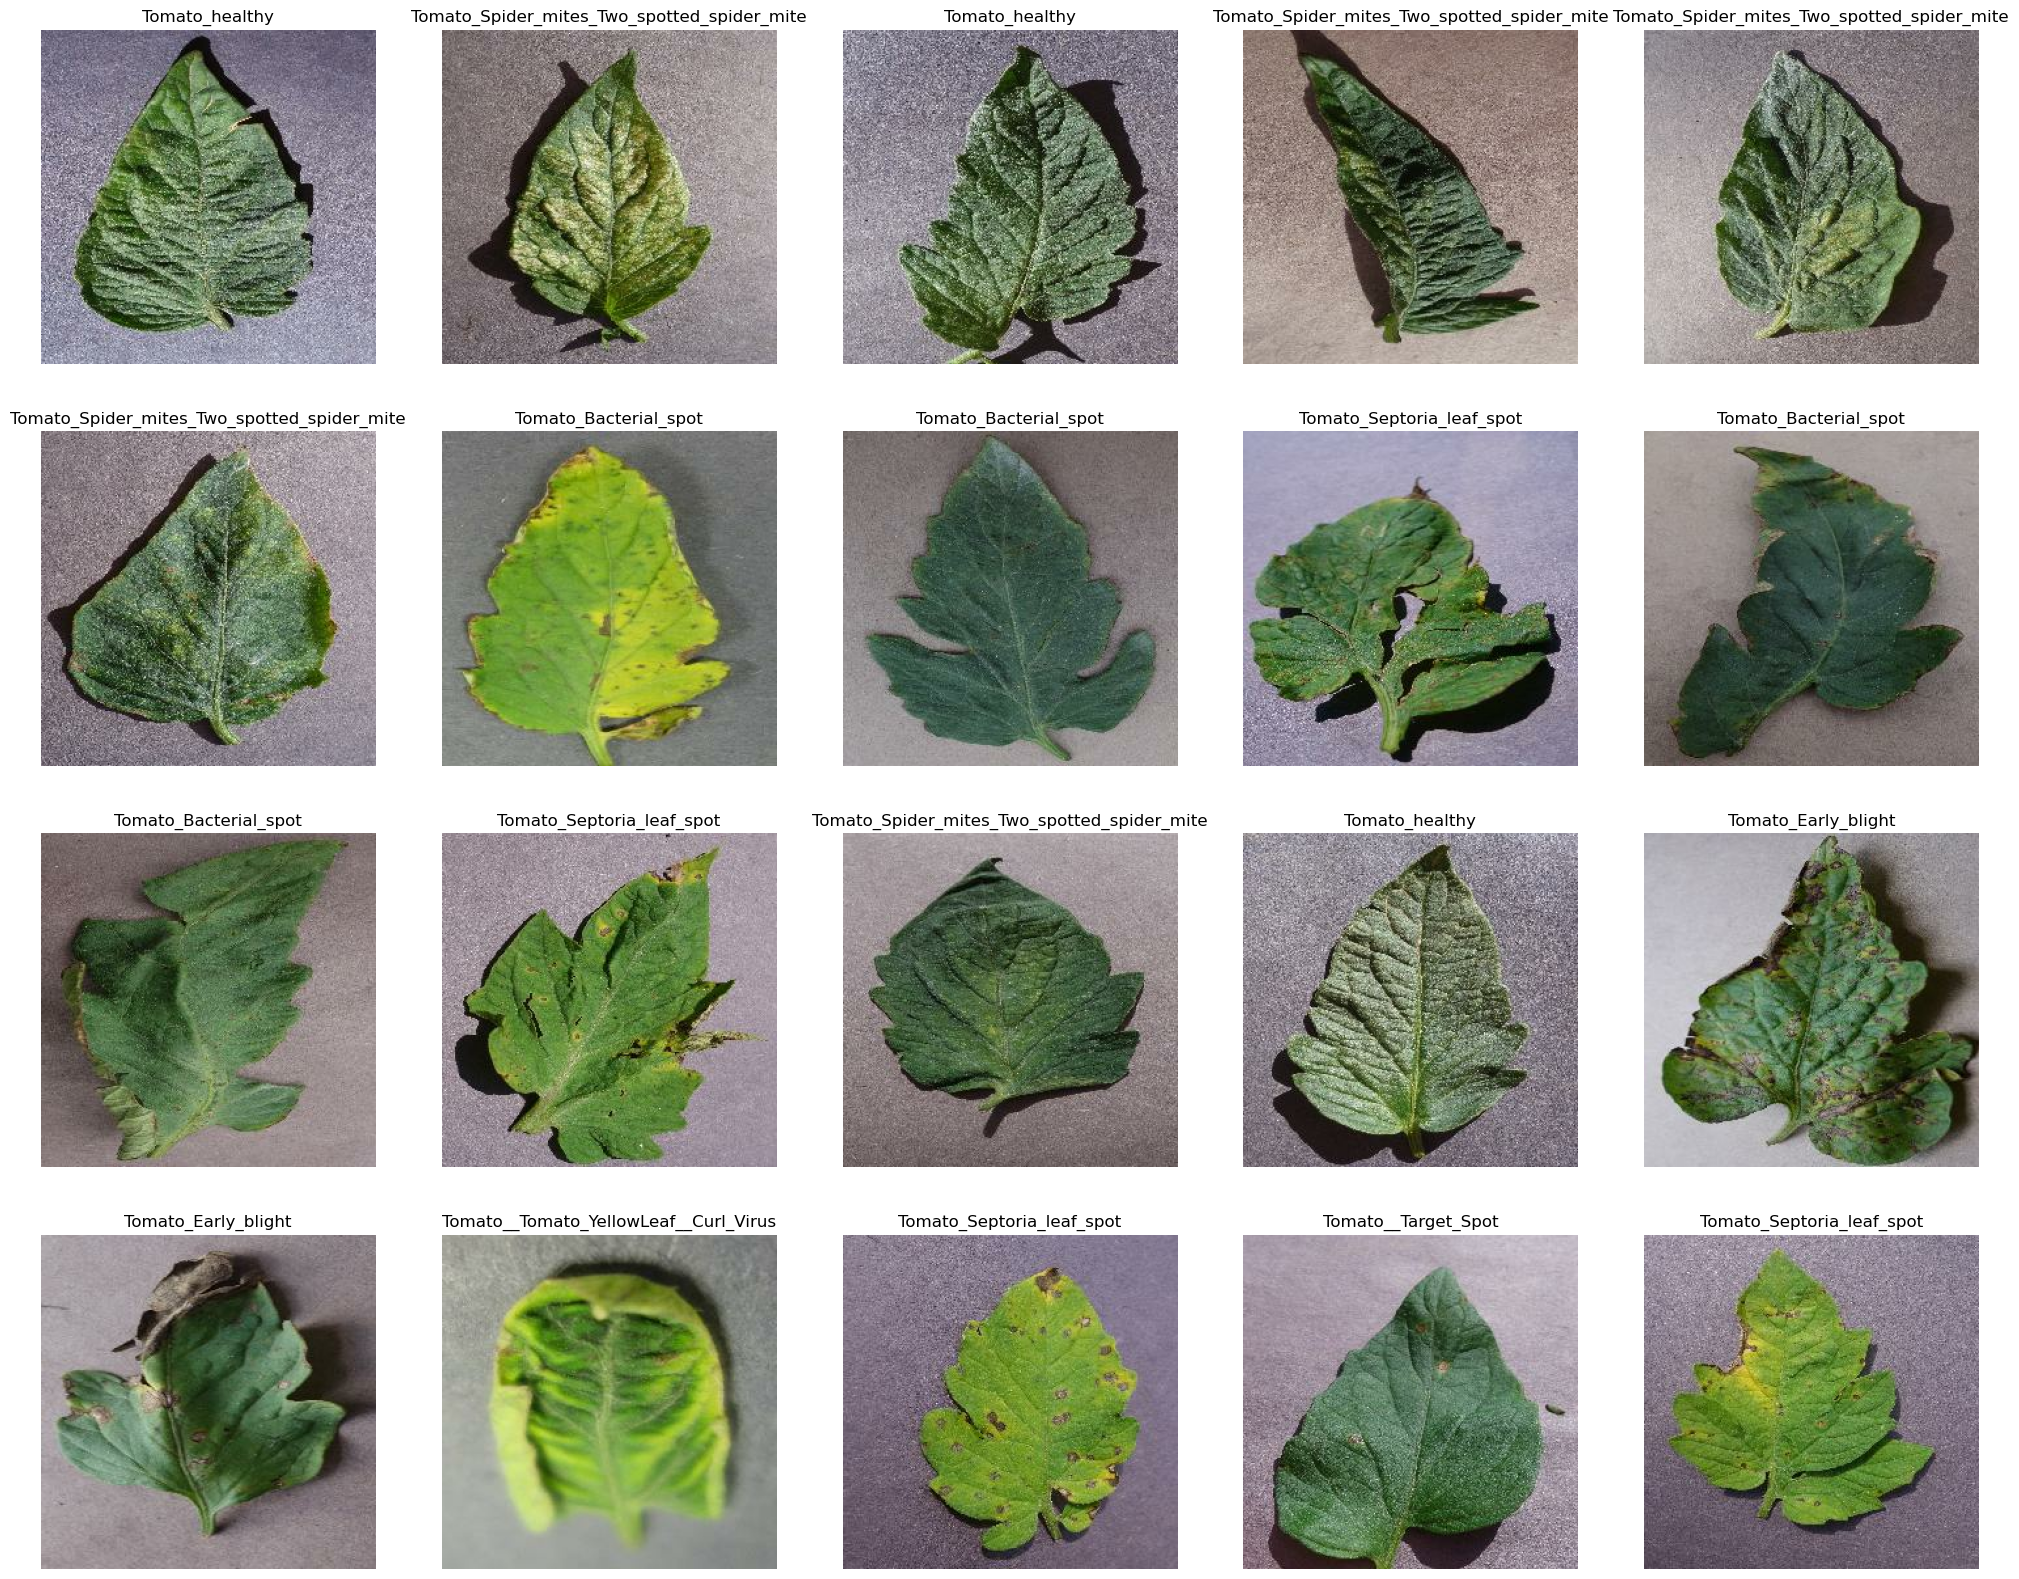

In [14]:
plt.figure(figsize=(25,20))
for image_batch, label_batch in dataset.take(1):
    for i in range(20):
        ax = plt.subplot(4,5, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
    #print(image_batch[0])

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [29]:
len(train_ds)

400

In [28]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [30]:
resize_and_rescale = tf.keras.Sequential([layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
                    layers.experimental.preprocessing.Rescaling(1.0/255)])

In [31]:
data_augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
                                        layers.experimental.preprocessing.RandomRotation(0.2),])

In [36]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)
EPOCHS = 5
model = models.Sequential([resize_and_rescale,
                          data_augmentation,
                          layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
                          layers.MaxPooling2D((2, 2)),
                          layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
                          layers.MaxPooling2D((2, 2)),
                          layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
                          layers.MaxPooling2D((2, 2)),
                          layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
                          layers.MaxPooling2D((2, 2)),
                          layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
                          layers.MaxPooling2D((2, 2)),
                          layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
                          layers.MaxPooling2D((2, 2)),
                          layers.Flatten(),
                          layers.Dense(64, activation='relu'),
                          layers.Dense(n_classes, activation= 'softmax')
                          ])
model.build(input_shape = input_shape)

In [37]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_7 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_24 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                               

In [38]:
model.compile(
optimizer= 'adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy'])

In [39]:
history = model.fit(train_ds,
    epochs=EPOCHS,
    verbose=1,
    validation_data=val_ds)

Epoch 1/5
400/400 [==============================] - 25501s 60s/step - loss: 1.5228 - accuracy: 0.4677 - val_loss: 1.2488 - val_accuracy: 0.5869
Epoch 2/5
400/400 [==============================] - 2156s 5s/step - loss: 0.9485 - accuracy: 0.6656 - val_loss: 2.0227 - val_accuracy: 0.4762
Epoch 3/5
400/400 [==============================] - 2303s 6s/step - loss: 0.7159 - accuracy: 0.7521 - val_loss: 0.8869 - val_accuracy: 0.6975
Epoch 4/5
400/400 [==============================] - 2832s 7s/step - loss: 0.5625 - accuracy: 0.7997 - val_loss: 0.8626 - val_accuracy: 0.7256
Epoch 5/5
400/400 [==============================] - 3512s 9s/step - loss: 0.4762 - accuracy: 0.8335 - val_loss: 0.4560 - val_accuracy: 0.8369


In [40]:
scores = model.evaluate(test_ds)

51/51 [==============================] - 2189s 2s/step - loss: 0.4587 - accuracy: 0.8395


In [41]:
scores

[0.4586687982082367, 0.8394607901573181]

In [42]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 400}

In [43]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

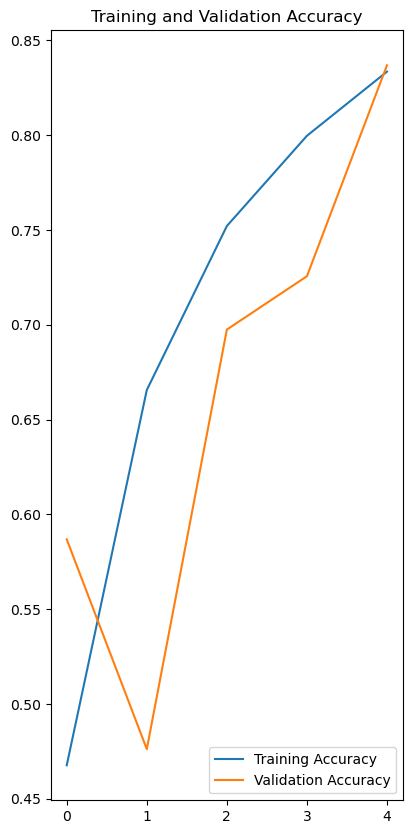

In [45]:
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss')

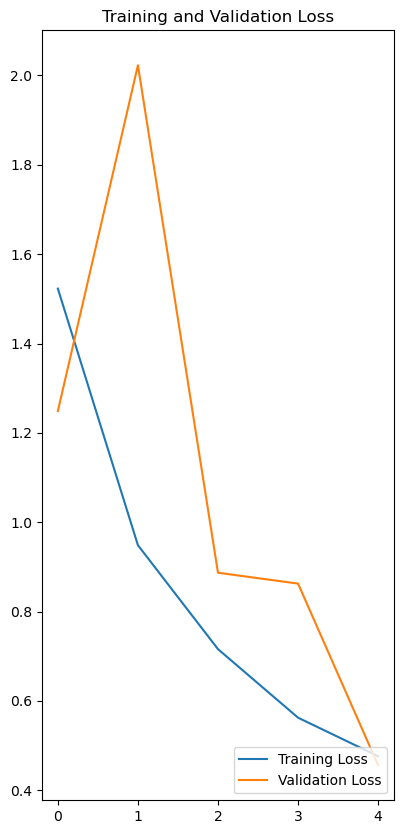

In [46]:
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

first image to predict
actual label: Tomato__Tomato_YellowLeaf__Curl_Virus
1/1 [==============================] - 15s 15s/step
predicted label: Tomato__Tomato_YellowLeaf__Curl_Virus


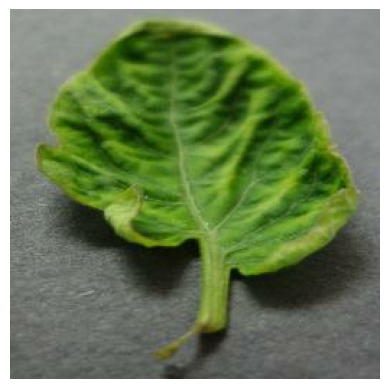

In [47]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    plt.axis('off')
    print("actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])
    

In [48]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 135ms/step


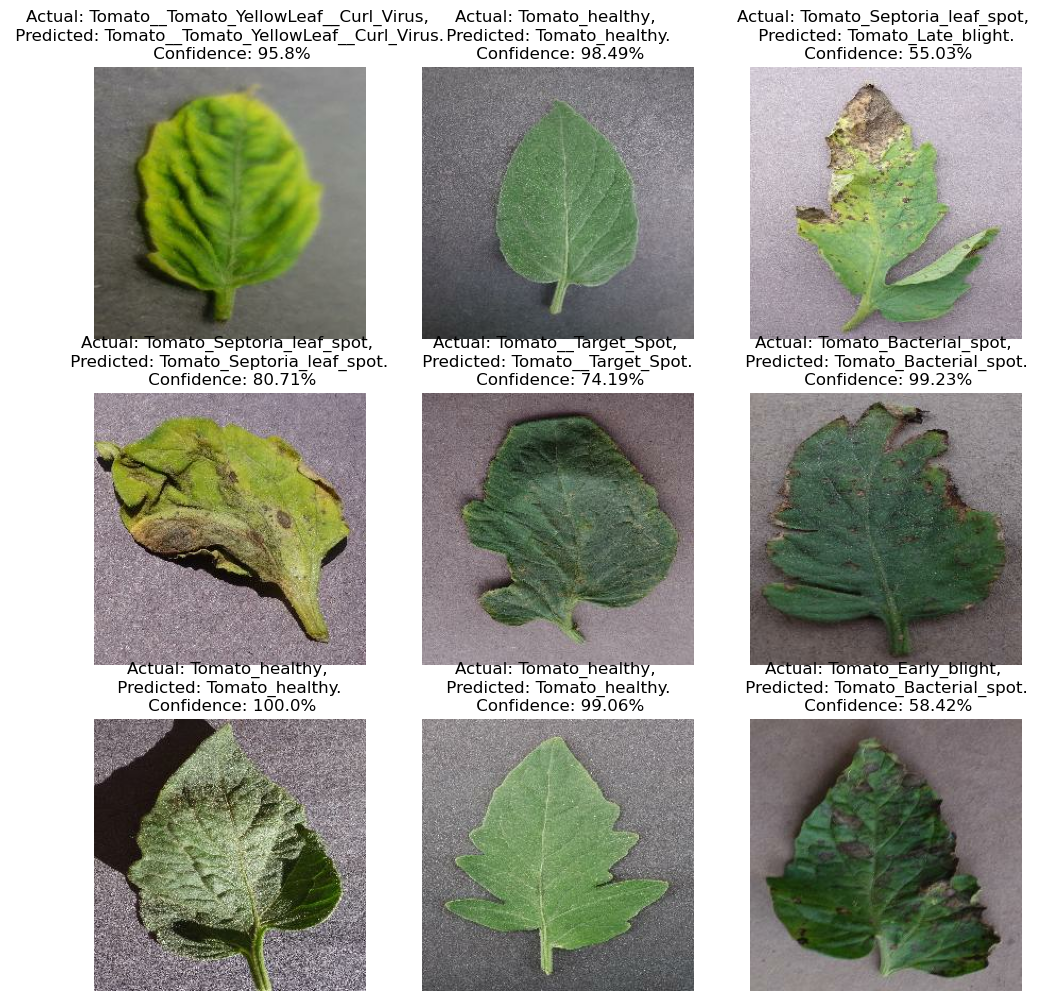

In [49]:
plt.figure(figsize=(12,12))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        plt.axis('off')

In [50]:
model_version=1
model.save(f"./saved_models/{model_version}")

INFO:tensorflow:Assets written to: ./saved_models/1\assets


INFO:tensorflow:Assets written to: ./saved_models/1\assets


In [51]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.13.0
